In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model, metrics, preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("diamonds.csv", index_col=0)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


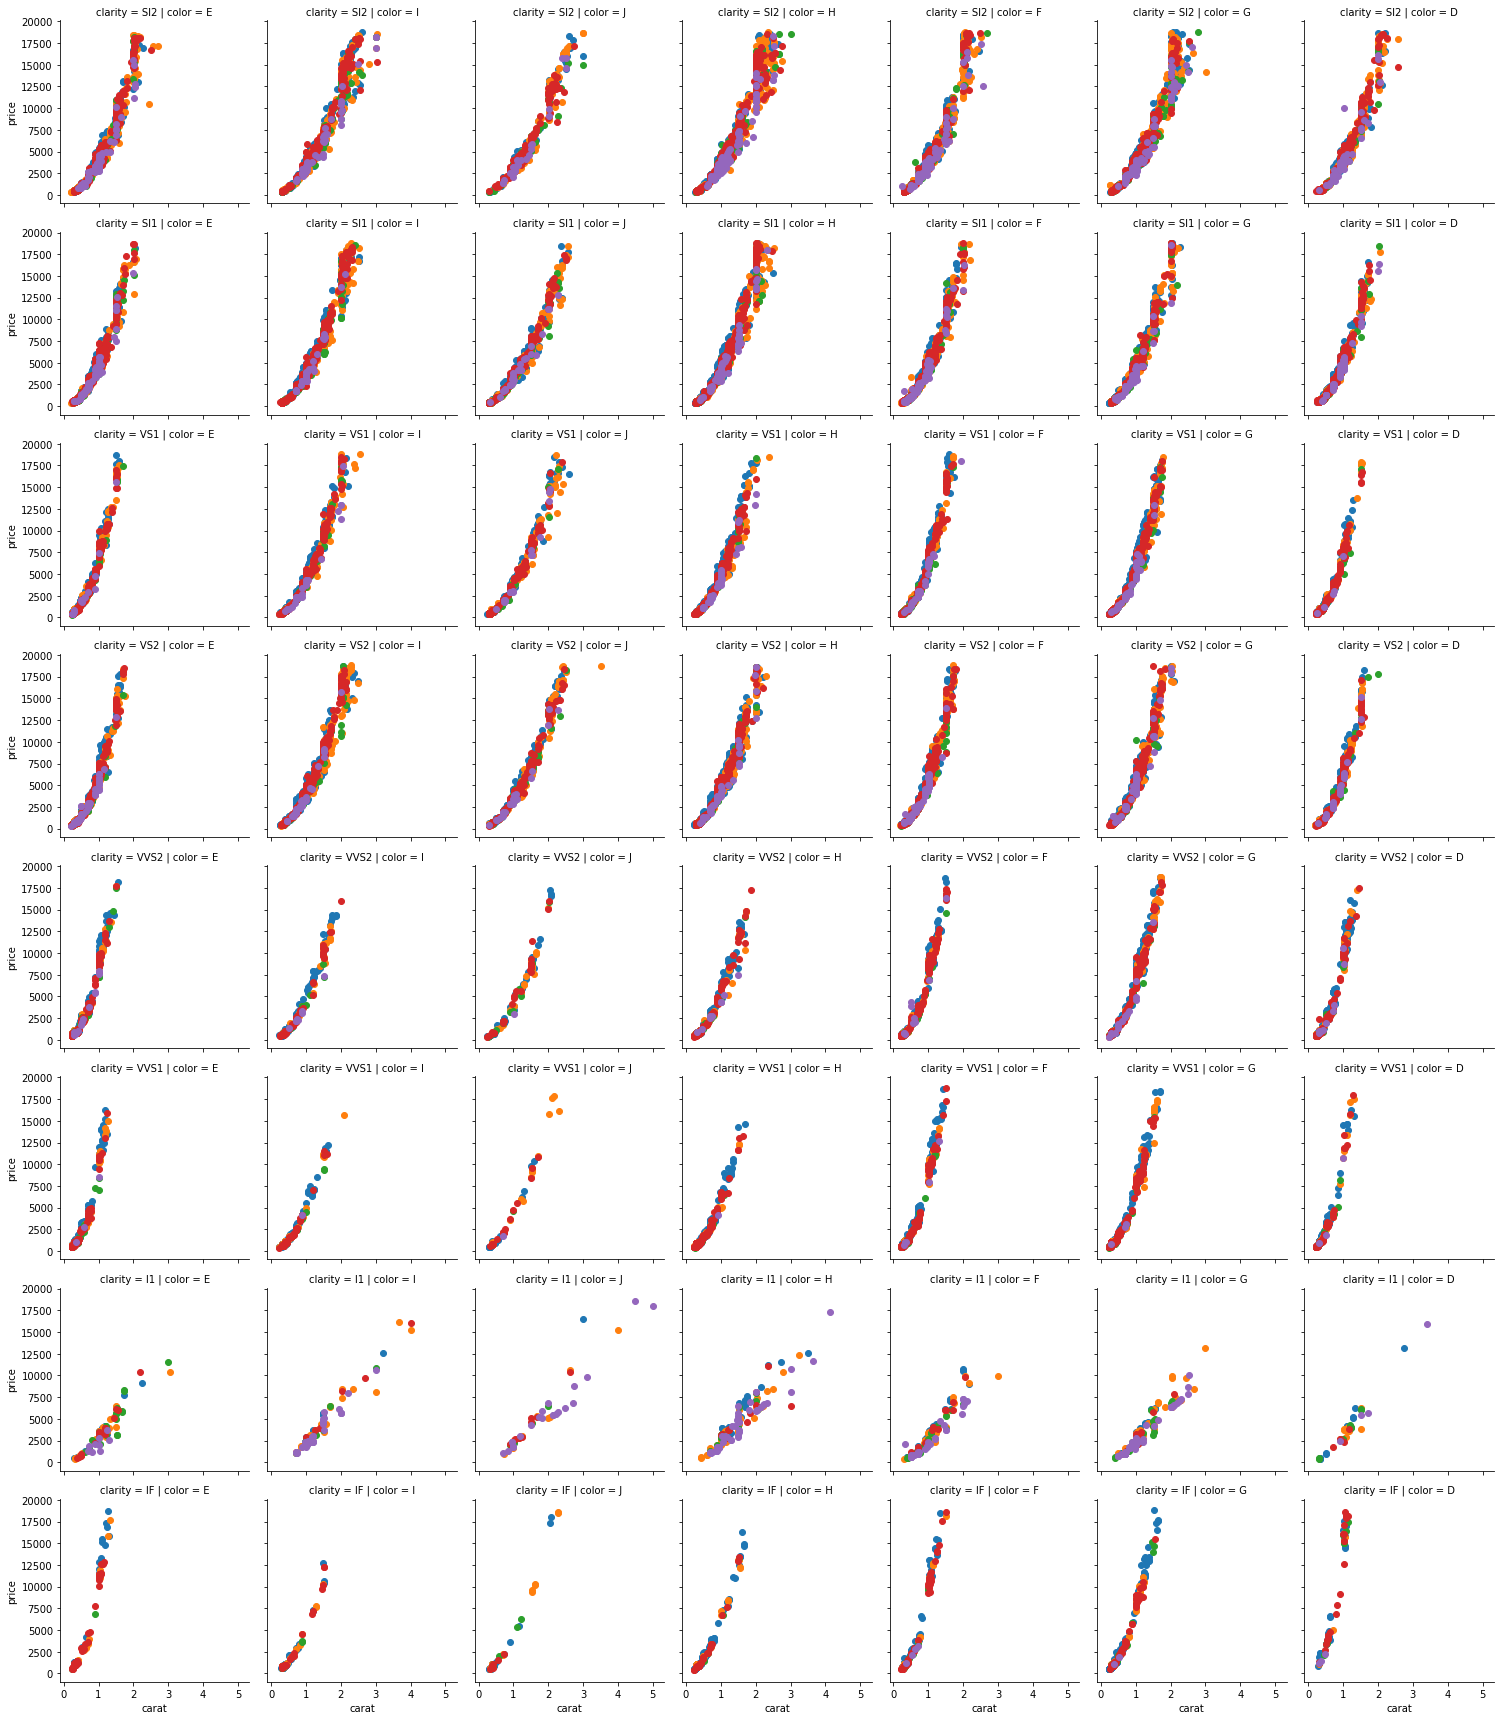

In [4]:
g = sns.FacetGrid(df, col='color',row='clarity',hue='cut')
g = g.map(plt.scatter,'carat','price')

### Split the dataset for testing

In [5]:
y = df['price'].astype('float64')
x = df.drop(columns='price')
x.head()

,carat,cut,color,clarity,depth,table,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

### Preprocessing

1) Scale data for the algorithm; support vector algos perform poorly without scaling  <br> 2) One hot encode the categorical variables <br> The training and testing data are converted from pandas objects to numpy arrays for sklearn

In [20]:
scalerx = preprocessing.StandardScaler()
numerical_var = ['carat','depth','table','x','y','z']
categorical_var = ['cut','color','clarity']
x_train_num = scalerx.fit_transform(x_train[numerical_var]) #returns a np array
x_train_dum = pd.get_dummies(x_train[categorical_var]).values #convert to np array
x_scaled = np.concatenate([x_train_num, x_train_dum], axis=1)
#x_train_num.shape
#x_scaled.shape

In [8]:
scalery = preprocessing.StandardScaler()
y_train = y_train.values.reshape(-1,1)
y_scaled = scalery.fit_transform(y_train)

In [9]:
x_test_num = scalerx.transform(x_test[numerical_var])
x_test_dum = pd.get_dummies(x_test[categorical_var]).values
x_test_scaled = np.concatenate([x_test_num, x_test_dum],axis=1)

In [10]:
y_test = y_test.values.reshape(-1,1)
y_test_scaled = scalery.transform(y_test)

In [11]:
lr = linear_model.LinearRegression()
model = lr.fit(x_scaled, y_scaled)
model.score(x_test_scaled, y_test_scaled)

0.9198128676983796

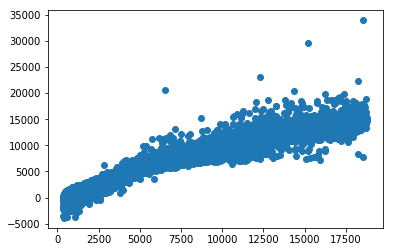

In [12]:
plt.scatter(y_test,scalery.inverse_transform(model.predict(x_test_scaled)))
plt.xlabel('Real prices ($)')
plt.ylabel('Predicted prices ($)')

Predictions are bad for higher prices. Furthermore, there is a substantial number of negative prices predicted.

### SVR - linear and rbf kernel

y_train and y_test are converted from column vectors to 1d arrays as required by SVR

In [22]:
clf_linear = SVR(kernel='linear',cache_size=500)
clf_linear.fit(x_scaled, y_scaled.ravel())

SVR(C=1.0, cache_size=500, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [23]:
clf_linear.score(x_test_scaled, y_test_scaled.ravel())

0.9103580680454768

Using a linear kernel results in a worse score than linear regression. This indicates that the data is likely non-linearly separable.

In [54]:
clf_rbf = SVR(kernel='rbf', cache_size=500)
clf_rbf.fit(x_scaled, y_scaled.ravel())

SVR(C=1.0, cache_size=500, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [25]:
clf_rbf.score(x_test_scaled, y_test_scaled.ravel())

0.9730587846095219

In [26]:
print("The number of support vectors is %d and the number of data points used for training is %d. The out-of-sample error bound is %.1f%%" 
      %(clf_rbf.support_vectors_.shape[0], x_scaled.shape[0],clf_rbf.support_vectors_.shape[0]/ (x_scaled.shape[0]-1)*100))

The number of support vectors is 9843 and the number of data points used for training is 40455. The out-of-sample error bound is 24.3%


Text(0.5,1,'Prediction vs Real Prices')

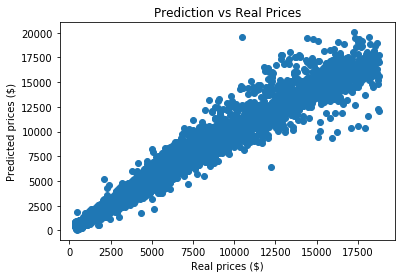

In [55]:
svrpredict = clf_rbf.predict(x_test_scaled)
y_predict = scalery.inverse_transform(svrpredict)
plt.scatter(y_test, y_predict)
plt.xlabel('Real prices ($)')
plt.ylabel('Predicted prices ($)')
plt.title('Prediction vs Real Prices')

SVR predictions show closer correspondence with the test data.

### Use K-fold cross-validation to try and find a better penalty term

In [28]:
scalerY = preprocessing.StandardScaler()
Y_scaled = scalerY.fit_transform(y.values.reshape(-1,1))

In [29]:
scalerX = preprocessing.StandardScaler()
X_num = scalerX.fit_transform(x[numerical_var])
X_dum = pd.get_dummies(x[categorical_var]).values
X_scaled = np.concatenate([X_num, X_dum], axis=1)

In [34]:
#GridSearch takes too long to find C, but C=10 is a better estimator than C=100 if allowed to run.
#parameters = {'C':[1, 10, 100], 'kernel':['rbf']}
#svr = GridSearchCV(SVR(), cv=5, param_grid=parameters)
#svr.fit(X_scaled, Y_scaled.ravel())

In [22]:
clf_rbf1 = SVR(C=1, kernel='rbf', cache_size=500)
clf_rbf2 = SVR(C=10, kernel='rbf', cache_size=500)
clf_rbf3 = SVR(C=100, kernel='rbf', cache_size=500)
#clf_rbf4 = SVR(C=1000, kernel='rbf', cache_size=500)

In [27]:
scores = cross_val_score(clf_rbf1, X_scaled, Y_scaled.ravel(), cv=KFold(n_splits=5,shuffle=True))
scores

array([0.97318899, 0.97278849, 0.97525282, 0.97465641, 0.9762103 ])

In [28]:
scores = cross_val_score(clf_rbf2, X_scaled, Y_scaled.ravel(), cv=KFold(n_splits=5,shuffle=True))
scores

array([0.97869856, 0.97917692, 0.97934473, 0.97785958, 0.97776415])

In [29]:
scores = cross_val_score(clf_rbf3, X_scaled, Y_scaled.ravel(), cv=KFold(n_splits=5,shuffle=True))
scores

array([0.97909515, 0.97817265, 0.97801011, 0.97987779, 0.97819359])

No noticeable difference in requiring a harder margin when going from C=10 to C=100.

### SGDRegressor

The number of samples is fairly large, so we can try SGDRegressor

In [44]:
clf_SGD = linear_model.SGDRegressor(max_iter=1e6, tol=1e-5) #number of rows is about 40,000. 25 iterations needed to get 1 million steps
clf_SGD.fit(x_scaled, y_scaled.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=1000000.0, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=1e-05, verbose=0,
       warm_start=False)

In [45]:
clf_SGD.score(x_test_scaled, y_test_scaled.ravel())

0.9180242948365581

In [36]:
params = {'eta0':[1e-1,1e-2,1e-3,1e-4], 'max_iter':[1e3,1e4,1e5,1e6],'power_t':[0.1,0.25,0.4]}
clf_grid = GridSearchCV(linear_model.SGDRegressor(tol=1e-5), param_grid=params)
clf_grid.fit(x_scaled, y_scaled.ravel())
clf_grid.best_estimator_

C:\Users\Alsen\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Alsen\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.001,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=100000.0, n_iter=None, penalty='l2',
       power_t=0.1, random_state=None, shuffle=True, tol=1e-05, verbose=0,
       warm_start=False)

In [40]:
clf_SGD2 = linear_model.SGDRegressor(eta0=0.001, max_iter=1e6, power_t=0.1, tol=1e-5) #number of rows is about 40,000. 25 iterations needed to get 1 million steps
clf_SGD2.fit(x_scaled, y_scaled.ravel())
clf_SGD2.score(x_test_scaled, y_test_scaled.ravel())

0.9179134565973351

### Random Forest Regressor

In [52]:
rf = RandomForestRegressor()
rf.fit(x_scaled, y_scaled.ravel())
rf.score(x_test_scaled, y_test_scaled.ravel())

0.9800101951705562

Text(0.5,1,'Prediction vs Real Prices')

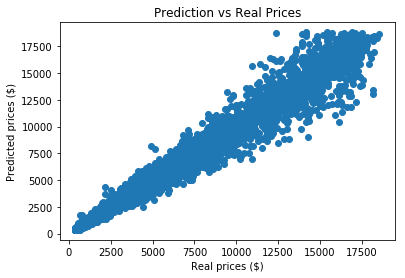

In [60]:
rf_predict = scalery.inverse_transform(rf.predict(x_test_scaled))
plt.scatter(rf_predict,y_test)
plt.xlabel('Real prices ($)')
plt.ylabel('Predicted prices ($)')
plt.title('Prediction vs Real Prices')

Lower tendency to under-estimate prices at the higher price range as compared to SVR

Text(0.5,1,'Variable Importances')

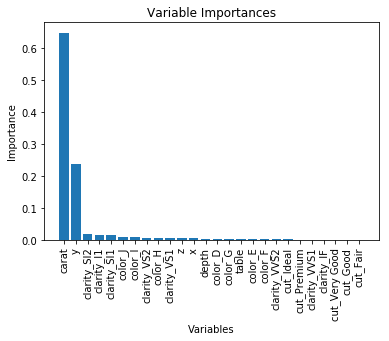

In [66]:
importances = rf.feature_importances_
indices = np.argsort(-importances) #add a negative sign to get feature importances in descending order
plt.bar(labels[indices], importances[indices], orientation='vertical')
plt.xticks(labels, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variables')
plt.title('Variable Importances')

Carat and y contribute most significantly. Cut does not seem to have significant contribution.